# Assignment 2

### Kyle Lacson | May 28, 2023

### Importing Libraries

In [1]:
### Importing libraries
import pandas as pd # for dataframe and data manipulation
import string
import nltk # package for processing natural langauge related tasks
import matplotlib.pyplot as plt # for visual or graphing data

### Importing specific functions/methods 
from sklearn.model_selection import train_test_split # package used to split the full dataset into training data and testing data under a specific seed
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # provides a classification report of the confusion matrix with accuracy, precision, recall, etc...
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier
from sklearn.tree import DecisionTreeClassifier # sklearn's Decision Tree classifier
from sklearn.neighbors import KNeighborsClassifier # sklearn's k-nearest neighbor classifier
from sklearn.feature_extraction.text import CountVectorizer # sklearns package for text mining (feature latent space)

# Remove warning texts
import warnings 
warnings.filterwarnings('ignore')


### Importing the dataset

In [2]:
df = pd.read_csv('critics.csv') # importing the critics.csv into python

### Parsing required data

In [3]:
df = df[~df['quote'].isnull()] # removes null rows 
df = df.reset_index(drop=True) # reset index numbering

In [4]:
df.quote.apply(lambda x: True if "'" in x else False).sum() # checking on how many rows have an apostraphe within the quotes column

6165

In [5]:
df['fresh'].unique() # check the unique values of the 'fresh' column

array(['fresh', 'rotten', 'none'], dtype=object)

### Fresh and Rotten

In [6]:
df = df[df['fresh'].isin(['fresh','rotten'])] # return the rows that contain the keywords 'fresh' and 'rotten'

### Tokenizer Classes

In [7]:
class LemmStopWordsTokenizer(object): # class for lemmatization and stop words <- will be used within the countvectorizer tokenization parameter
    def __init__(self):
        self.lemmer = nltk.stem.WordNetLemmatizer() # nltk lemmatizer package
        stop_words_list = [nltk.word_tokenize(word) for word in nltk.corpus.stopwords.words('English')] # creating a list out of the stop words from the corpus package and tokenizing each word
        stop_words_flattened = set([item for sublist in stop_words_list for item in sublist]) # creates a set list that reduces the dimensionality of the list
        self.stop_words = list(stop_words_flattened) + list(string.punctuation) # initialize a list of all tokenized stop words and punctuation
        
    def __call__(self, doc):
        return [self.lemmer.lemmatize(t) for t in nltk.word_tokenize(doc) if t not in self.stop_words] # calls the function to tokenize, stem, and remove all stop words

class StemStopWordsTokenizer(object): # class for stemming and stop words <- will be used within the countvectorizer tokenization parameter
    def __init__(self):
        self.stemmer = nltk.stem.PorterStemmer() # nltk stemmer package
        stop_words_list = [nltk.word_tokenize(word) for word in nltk.corpus.stopwords.words('English')] # creating a list out of the stop words from the corpus package and tokenizing each word
        stop_words_flattened = set([item for sublist in stop_words_list for item in sublist]) # creates a set list that reduces the dimensionality of the list
        self.stop_words = list(stop_words_flattened) + list(string.punctuation) # initialize a list of all tokenized stop words and punctuation
        
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in nltk.word_tokenize(doc) if t not in self.stop_words]

class StemTokenizer(object): # class for stemming <- will be used within the countvectorizer tokenization parameter
    def __init__(self):
        self.stemmer = nltk.stem.PorterStemmer() # nltk stemmer package
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in nltk.word_tokenize(doc)]

**Notes:**

Using sklearn's text feature extraction package, a class that encompassed some pre-processing steps was initalized. Within this class consists of the following pre-processing steps:

Vectorizer1
1. Lemmatizing
2. Removed stop words from the NLTK corpus package
3. Stripped the accent's off (this includes apostraphe's)

Vectorizer2
1. Stemming 
2. Removed stop words from the NLTK corpus package 
3. Stripped the accent's off (this includes apostraphe's)

Vectorizer3
1. Stemming

In [8]:
def process_classification(vector_input = '1' or '2' or '3', classifier = 'naive_bayes' or 'decision_tree' or 'knn'):
    
    if vector_input == '1': # the vector input parameter denotes which tokenizer to use as shown in the notes above
        
        vectorizer = CountVectorizer(
        lowercase = True, # normalize all the text
        tokenizer = LemmStopWordsTokenizer(), # tokenizer implementation 
        strip_accents = 'unicode' # remove the accents and apostraphe's
        ) # initializing CountVectorizer function from sklearn feature_extraction library
        
    elif vector_input == '2': # vector input parameter denotes which tokenizer to use as shown in the notes above
    
        vectorizer = CountVectorizer(
            lowercase = True,
            tokenizer = StemStopWordsTokenizer(),
            strip_accents = 'unicode'
        ) # initializing CountVectorizer function from sklearn feature_extraction library
    
    elif vector_input == '3': # vector input parameter denotes which tokenizer to use as shown in the notes above

        vectorizer = CountVectorizer(
            lowercase = True,
            tokenizer = StemTokenizer(),
            strip_accents = None
        ) # initializing CountVectorizer function from sklearn feature_extraction library
        
    vectorized = vectorizer.fit_transform(df['quote']) # fitting and transforming the 'quote' column onto the intialized vectorizer
    
    X = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names_out()) # sparse matrix of unique words and the number of samples in the main dataframe
    y = df['fresh'] == 'fresh' # target label <- boolean series that determine fresh or not
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) # splitting the full dataframe of both the predictor and response variables
   
    if classifier == 'naive_bayes': # naive bayes classification classifier if 'classifier' parameter is set to naive_bayes
        classifier_alg = MultinomialNB(alpha=0.01)
    elif classifier == 'decision_tree': # decision tree classification classifier if 'classifier' parameter is set to 'decision_tree'
        classifier_alg = DecisionTreeClassifier()
    elif classifier == 'knn': # k-nearest neighbors classification classifier if 'classifier' parameter is set to 'knn'
        classifier_alg = KNeighborsClassifier()
    
    classifier_alg.fit(X_train,y_train) # fitting the training features and training response variable to the trained algorithm
    
    y_pred = classifier_alg.predict(X_test) # y values predicted using the trained model with the test data
    
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred, labels = classifier_alg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classifier_alg.classes_) # create the confusion matrix for the classifier
    print(f'Vectorizer input: {vector_input}   |   Classifier: {classifier} \n\n\n')
    disp.plot()
    plt.show()
    print(classification_report(y_test,y_pred))

Vectorizer input: 1   |   Classifier: naive_bayes 





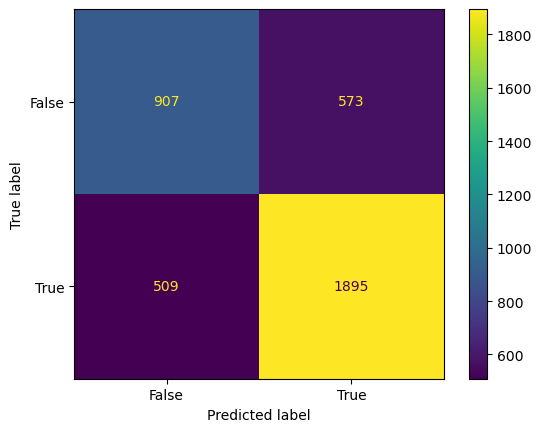

              precision    recall  f1-score   support

       False       0.64      0.61      0.63      1480
        True       0.77      0.79      0.78      2404

    accuracy                           0.72      3884
   macro avg       0.70      0.70      0.70      3884
weighted avg       0.72      0.72      0.72      3884



In [9]:
process_classification(vector_input = '1', classifier = 'naive_bayes')

# lemmatization, stop words, strip accents, model: naive bayes

Vectorizer input: 1   |   Classifier: decision_tree 





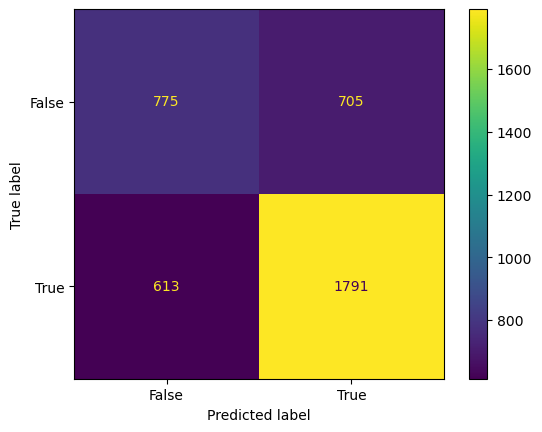

              precision    recall  f1-score   support

       False       0.56      0.52      0.54      1480
        True       0.72      0.75      0.73      2404

    accuracy                           0.66      3884
   macro avg       0.64      0.63      0.64      3884
weighted avg       0.66      0.66      0.66      3884



In [10]:
process_classification(vector_input = '1', classifier = 'decision_tree')

# lemmatization, removed stop words, stripped accents, model decision tree

Vectorizer input: 2   |   Classifier: naive_bayes 





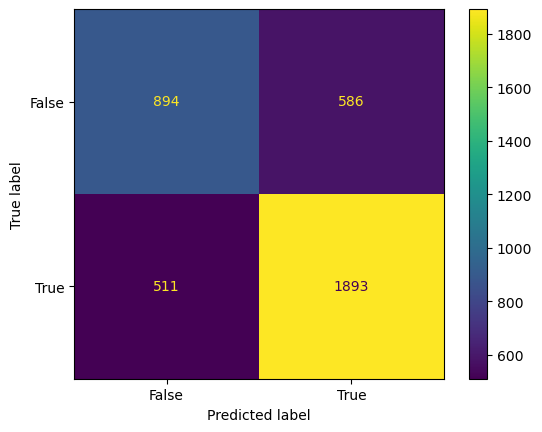

              precision    recall  f1-score   support

       False       0.64      0.60      0.62      1480
        True       0.76      0.79      0.78      2404

    accuracy                           0.72      3884
   macro avg       0.70      0.70      0.70      3884
weighted avg       0.72      0.72      0.72      3884



In [11]:
process_classification(vector_input = '2', classifier = 'naive_bayes')

# stemming, stop words, striped accents, model: naive bayes

Vectorizer input: 2   |   Classifier: decision_tree 





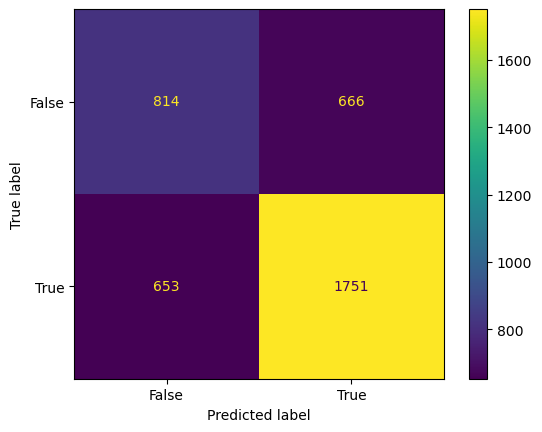

              precision    recall  f1-score   support

       False       0.55      0.55      0.55      1480
        True       0.72      0.73      0.73      2404

    accuracy                           0.66      3884
   macro avg       0.64      0.64      0.64      3884
weighted avg       0.66      0.66      0.66      3884



In [12]:
process_classification(vector_input = '2', classifier = 'decision_tree')

# stemming, stop words, strip accents, model: decision tree

Vectorizer input: 3   |   Classifier: naive_bayes 





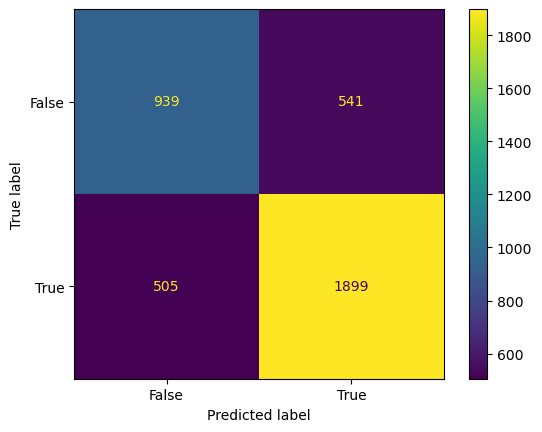

              precision    recall  f1-score   support

       False       0.65      0.63      0.64      1480
        True       0.78      0.79      0.78      2404

    accuracy                           0.73      3884
   macro avg       0.71      0.71      0.71      3884
weighted avg       0.73      0.73      0.73      3884



In [13]:
process_classification('3','naive_bayes')

# stemming, model: naive bayes

Vectorizer input: 3   |   Classifier: decision_tree 





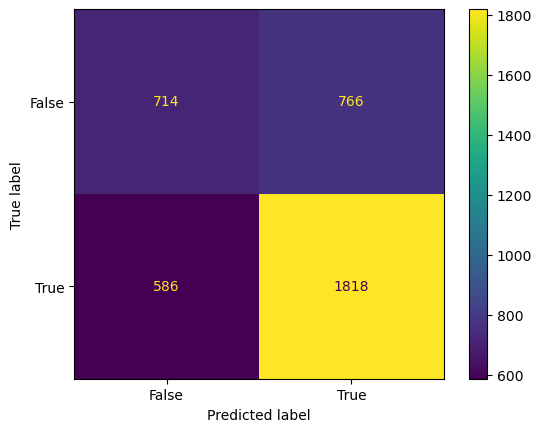

              precision    recall  f1-score   support

       False       0.55      0.48      0.51      1480
        True       0.70      0.76      0.73      2404

    accuracy                           0.65      3884
   macro avg       0.63      0.62      0.62      3884
weighted avg       0.64      0.65      0.65      3884



In [14]:
process_classification('3','decision_tree')

# stemming, model: decision tree

Vectorizer input: 1   |   Classifier: knn 





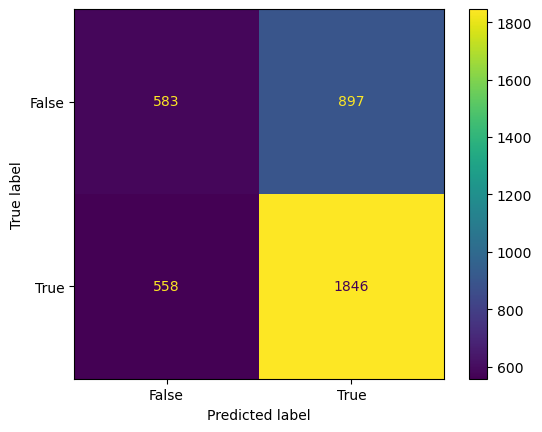

              precision    recall  f1-score   support

       False       0.51      0.39      0.44      1480
        True       0.67      0.77      0.72      2404

    accuracy                           0.63      3884
   macro avg       0.59      0.58      0.58      3884
weighted avg       0.61      0.63      0.61      3884



In [15]:
process_classification('1','knn')

# lemmatization, stop words, strip accents, model: knn

Vectorizer input: 3   |   Classifier: knn 





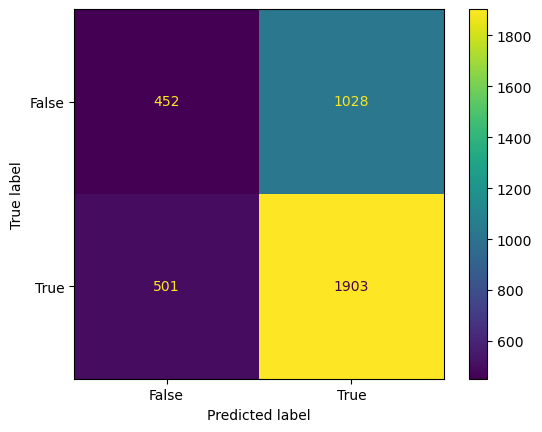

              precision    recall  f1-score   support

       False       0.47      0.31      0.37      1480
        True       0.65      0.79      0.71      2404

    accuracy                           0.61      3884
   macro avg       0.56      0.55      0.54      3884
weighted avg       0.58      0.61      0.58      3884



In [16]:
process_classification('3','knn')

# stemming, model: knn

In [17]:
from transformers import pipeline # using the transformers package for it's pipeline framework

In [18]:
sentiment_pipeline = pipeline('sentiment-analysis') # using the in-package pipeline function that contains the sentiment-analysis feature

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [19]:
sent_analysis_list = df.quote.apply(lambda x: sentiment_pipeline(x)[0]) # sentiment score and analysis list

In [20]:
df['sentiment_label'] = sent_analysis_list # creating the new column for sentiment labels

In [21]:
df.sentiment_label = df.sentiment_label.apply(lambda x: x['label']) # replacing the dictionary with the label 'POSITIVE' or 'NEGATIVE'

In [22]:
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title,sentiment_label
0,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story,POSITIVE
1,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story,POSITIVE
2,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story,POSITIVE
3,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story,POSITIVE
4,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story,POSITIVE


### Write-up

**Preprocessing**

For the preprocessing steps of the data, each sample of text must be tokenized. The method of tokenizing consists of splitting each word or element based on some delimiter. By obtaining each token, each token can be preprocessed to improve the training and performance of the algorithm. 
There are three major preprocessing that was performed on the data in different combinations. 
- The first of these changes was normalizing the each row by lowercasing each individual element of the strings. T

- The second step is to remove any stop words within each 'quote'. These stop words are articles or non-important words that do not provide much context to the sentence. 

- Third is to apply some kind of stemming or lemmatization application to each individual token.

I created a function to run through multiple iterations of pre-processing. From the diffrent examples found above, stemming on the data seemed to provide slightly better results. There was a smaller variation between using stemming versus lemmatization on the different tokens. 

**Classifier Algorithm** 

For the different classification algorithm, I chose three different classification algorithms. Naive bayes, decision trees, and k-nearest neighbors was used as supervised classification algorithms to predict whether a movie was rated as 'fresh' or 'rotten' based on the quotes left on each movie. It seems as though the max accuracy I was able to obtain was about 74% using a combination of different preprocessing steps and different classification techniques. In order to increase the accuracy, carefully testing different algoirthms and hyperparameters is needed. The results were varied across the different combinations but given more resources and time, exploring the differents hyperparmeters may greatly improve the testing accuracies on the training data.

**Sentiment Analysis**

For the sentiment analysis, I relied on the transformers package from python to apply to the quote column. The transformers package consists of a pipeline function that covered sentiment-analysis and provides a general classification of the given text; either 'POSITIVE' or 'NEGATIVE'. This provides a general consensous and whether the written response had positive remarks regarding the critic or negative remarks based on certains words detected.